In [1]:
import pandas as pd
from myopic_mces import MCES

# smiles_all = pd.read_csv('MassSpecGym.tsv', sep='\t').smiles.unique()
# smiles_a = smiles_all[:100]
# smiles_b = smiles_all[100:200]

In [2]:
# import matplotlib.pyplot  as plt
# import numpy as np
# import time
# from functools import lru_cache
# hit = 0

# @lru_cache
# def sim_actual(a,b):
#     global hit
#     hit += 1
#     return abs(a - b)

# def sim(a,b):
#     return sim_actual(*sorted((a,b)))
# sim_actual.cache_info
# a = np.random.randint(0, 1000, size=(100))
# b = np.random.randint(0, 1000, size=(100))
# a.sort(),b.sort()
# # ans = np.abs(a[:, None] - b[None, :])
# for e, en in zip(a, a[1:]):
#     sim(e, en)

# for e, en in zip(b, b[1:]):
#     sim(e, en)

# ans = np.zeros((100, 100))
# for i in range(100):
#     for j in range(100):
#         ans[i,j] = sim(a[i],b[j])
# plt.imshow(ans)
# print(hit)

In [3]:
from myopic_mces import construct_graph
from itertools import product
from tqdm.cli import tqdm
from IPython.display import clear_output
from functools import lru_cache
from myopic_mces import construct_graph
import pulp
import networkx as nx

smiles_a, smiles_b = ['CC(=O)OC1=CC=CC=C1C(=O)O'], ['CN1C=NC2=C1C(=O)N(C(=O)N2C)C']
g = construct_graph(smiles_a[0])
h = construct_graph(smiles_b[0])
# nx.draw(h)

In [5]:
from myopic_mces import MCES
MCES('CC(=O)OC1=CC=CC=C1C(=O)O', 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C')

(0, 26.5, 0.3404843807220459, 4)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/tornikeo/micromamba/envs/pb/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/4e819ffdeef84614a5e98dd3282622a7-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/4e819ffdeef84614a5e98dd3282622a7-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 453 COLUMNS
At line 2172 RHS
At line 2621 BOUNDS
At line 2831 ENDATA
Problem MODEL has 448 rows, 209 columns and 1221 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 7.5 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 23 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 23 strengthened rows, 0 substitutions
Cgl0004I processed model has 217 rows, 204 columns (204 integer (204 of which binary)) and 956 elements
Cutoff increment increased from 1e-05 to 0.4999
Cbc0038I Initial state - 0 

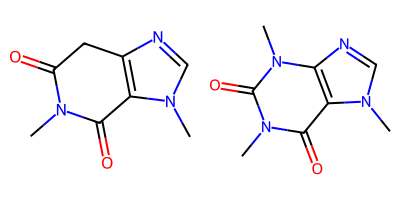

In [10]:
from rdkit import Chem
from rdkit.Chem import Draw
from myopic_mces import MCES
smiles_list = ['CN1C=NC2=C1C(=O)N(C)C(=O)C2', 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C']
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
print(MCES('CN1C=NC2=C1C(=O)N(C)C(=O)C2', 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'))
Draw.MolsToImage(mols)


In [12]:


def MCES_ILP(G1, G2, threshold, solver='default', solver_options={}, no_ilp_threshold=False):
    """
     Calculates the exact distance between two molecules using an ILP

     Parameters
     ----------
     G1 : networkx.classes.graph.Graph
         Graph representing the first molecule.
     G2 : networkx.classes.graph.Graph
         Graph representing the second molecule.
     threshold : float
         Threshold for the comparison. Exact distance is only calculated if the distance is lower than the threshold.
     solver: string
         ILP-solver used for solving MCES. Example:CPLEX_CMD
     solver_options: dict
         additional options to pass to solvers. Example: threads=1, msg=False for better multi-threaded performance
     no_ilp_threshold: bool
         if true, always return exact distance even if it is below the threshold (slower)

     Returns:
     -------
     float
         Distance between the molecules
     int
         Type of Distance:
             1 : Exact Distance
             2 : Lower bound (If the exact distance is above the threshold)

    """

    ILP=pulp.LpProblem("MCES", pulp.LpMinimize)

    #Variables for nodepairs
    nodepairs=[]
    for i in G1.nodes:
        for j in G2.nodes:
            if G1.nodes[i]["atom"]==G2.nodes[j]["atom"]:
                nodepairs.append(tuple([i,j]))
    y=pulp.LpVariable.dicts('nodepairs', nodepairs,
                            lowBound = 0,
                            upBound = 1,
                            cat = pulp.LpInteger)
    #variables for edgepairs and weight
    edgepairs=[]
    w={}
    for i in G1.edges:
        for j in G2.edges:
            if (G1.nodes[i[0]]["atom"]==G2.nodes[j[0]]["atom"] and G1.nodes[i[1]]["atom"]==G2.nodes[j[1]]["atom"]) or (G1.nodes[i[1]]["atom"]==G2.nodes[j[0]]["atom"] and G1.nodes[i[0]]["atom"]==G2.nodes[j[1]]["atom"]):
                edgepairs.append(tuple([i,j]))
                w[tuple([i,j])]=max(G1[i[0]][i[1]]["weight"],G2[j[0]][j[1]]["weight"])-min(G1[i[0]][i[1]]["weight"],G2[j[0]][j[1]]["weight"])

    #variables for not mapping an edge
    for i in G1.edges:
        edgepairs.append(tuple([i,-1]))
        w[tuple([i,-1])]=G1[i[0]][i[1]]["weight"]
    for j in G2.edges:
        edgepairs.append(tuple([-1,j]))
        w[tuple([-1,j])]=G2[j[0]][j[1]]["weight"]
    c=pulp.LpVariable.dicts('edgepairs', edgepairs,
                            lowBound = 0,
                            upBound = 1,
                            cat = pulp.LpInteger)

    #objective function
    ILP += pulp.lpSum([ w[i]*c[i] for i in edgepairs])

    #Every node in G1 can only be mapped to at most one in G2
    for i in G1.nodes:
        h=[]
        for j in G2.nodes:
            if G1.nodes[i]["atom"]==G2.nodes[j]["atom"]:
                h.append(tuple([i,j]))
        ILP+=pulp.lpSum([y[k] for k in h])<=1

    #Every node in G1 can only be mapped to at most one in G1
    for i in G2.nodes:
        h=[]
        for j in G1.nodes:
            if G1.nodes[j]["atom"]==G2.nodes[i]["atom"]:
                h.append(tuple([j,i]))
        ILP+=pulp.lpSum([y[k] for k in h])<=1

    #Every edge in G1 has to be mapped to an edge in G2 or the variable for not mapping has to be 1
    for i in G1.edges:
        ls=[]
        rs=[]
        for j in G2.edges:
            if (G1.nodes[i[0]]["atom"]==G2.nodes[j[0]]["atom"] and G1.nodes[i[1]]["atom"]==G2.nodes[j[1]]["atom"]) or (G1.nodes[i[1]]["atom"]==G2.nodes[j[0]]["atom"] and G1.nodes[i[0]]["atom"]==G2.nodes[j[1]]["atom"]):
                ls.append(tuple([i,j]))
        ILP+=pulp.lpSum([c[k] for k in ls])+c[tuple([i,-1])]==1

    #Every edge in G2 has to be mapped to an edge in G1 or the variable for not mapping has to be 1
    for i in G2.edges:
        ls=[]
        rs=[]
        for j in G1.edges:
            if (G1.nodes[j[0]]["atom"]==G2.nodes[i[0]]["atom"] and G1.nodes[j[1]]["atom"]==G2.nodes[i[1]]["atom"]) or (G1.nodes[j[1]]["atom"]==G2.nodes[i[0]]["atom"] and G1.nodes[j[0]]["atom"]==G2.nodes[i[1]]["atom"]):
                ls.append(tuple([j,i]))
        ILP+=pulp.lpSum([c[k] for k in ls])+c[tuple([-1,i])]==1

    #The mapping of the edges has to match the mapping of the nodes
    for i in G1.nodes:
        for j in G2.edges:
            ls=[]
            for k in G1.neighbors(i):
                if tuple([tuple([i,k]),j]) in c:
                    ls.append(tuple([tuple([i,k]),j]))
                else:
                    if  tuple([tuple([k,i]),j]) in c:
                        ls.append(tuple([tuple([k,i]),j]))
            rs=[]
            if G1.nodes[i]["atom"]==G2.nodes[j[0]]["atom"]:
                rs.append(tuple([i,j[0]]))
            if G1.nodes[i]["atom"]==G2.nodes[j[1]]["atom"]:
                rs.append(tuple([i,j[1]]))
            ILP+=pulp.lpSum([c[k] for k in ls])<=pulp.lpSum([y[k] for k in rs])


    for i in G2.nodes:
        for j in G1.edges:
            ls=[]
            for k in G2.neighbors(i):
                if tuple([j,tuple([i,k])]) in c:
                    ls.append(tuple([j,tuple([i,k])]))
                else:
                    if tuple([j,tuple([k,i])]) in c:
                        ls.append(tuple([j,tuple([k,i])]))
            rs=[]
            if G2.nodes[i]["atom"]==G1.nodes[j[0]]["atom"]:
                rs.append(tuple([j[0],i]))
            if G2.nodes[i]["atom"]==G1.nodes[j[1]]["atom"]:
                rs.append(tuple([j[1],i]))
            ILP+=pulp.lpSum([c[k] for k in ls])<=pulp.lpSum(y[k] for k in rs)

    #constraint for the threshold
    if threshold!=-1 and not no_ilp_threshold:
        ILP +=pulp.lpSum([ w[i]*c[i] for i in edgepairs])<=threshold
    # print(ILP)
    #solve the ILP
    if solver=="default":
        ILP.solve()
    else:
        sol=pulp.getSolver(solver, **solver_options)
        ILP.solve(sol)
    if ILP.status==1:
        return float(ILP.objective.value()),1, ILP
    else:
        return threshold,2,ILP

a,b = construct_graph('CN1C=NC2=C1C(=O)N(C)C(=O)C2'), \
        construct_graph('CN1C=NC2=C1C(=O)N(C(=O)N2C)C')
d, flag, prob = MCES_ILP(a,b, threshold=10)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/tornikeo/micromamba/envs/pb/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/025b4623dcf14a1ca3e84aebfe0c7d88-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/025b4623dcf14a1ca3e84aebfe0c7d88-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 453 COLUMNS
At line 2172 RHS
At line 2621 BOUNDS
At line 2831 ENDATA
Problem MODEL has 448 rows, 209 columns and 1221 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 7.5 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 23 strengthened rows, 0 substitutions
Cgl0003I 0 fixed, 0 tightened bounds, 23 strengthened rows, 0 substitutions
Cgl0004I processed model has 217 rows, 204 columns (204 integer (204 of which binary)) and 956 elements
Cutoff increment increased from 1e-05 to 0.4999
Cbc0038I Initial state - 0 

In [29]:
len(prob.variables())
prob.objective??

Type:        LpAffineExpression
String form: 0.5*edgepairs_((0,_1),_(1,_2)) + 0.5*edgepairs_((0,_1),_(1,_5)) + 0.5*edgepairs_((0,_1),_(2,_3)) + 0.5*edgepairs_((0,_1),_(3,_4)) + 0.5*edgepairs_((0,_1),_(4,_11)) + 0.5*edgepairs_((0,_1),_(6,_8)) + 0.5*edgepairs_((0,_1),_(8,_9)) + 0.5*edgepairs_((0,_1),_(9,_11)) + edgepairs_((0,_1),__1) + 0.5*edgepairs_((1,_2),_(0,_1)) + 0.5*edgepairs_((1,_2),_(11,_12)) + 0.5*edgepairs_((1,_2),_(8,_13)) + 1.5*edgepairs_((1,_2),__1) + 0.5*edgepairs_((1,_5),_(0,_1)) + 0.5*edgepairs_((1,_5),_(11,_12)) + 0.5*edgepairs_((1,_5),_(8,_13)) + 1.5*edgepairs_((1,_5),__1) + 2.0*edgepairs_((10,_11),__1) + 0.5*edgepairs_((10,_12),_(4,_5)) + 0.5*edgepairs_((10,_12),_(5,_6)) + edgepairs_((10,_12),__1) + 0.5*edgepairs_((2,_3),_(0,_1)) + 0.5*edgepairs_((2,_3),_(11,_12)) + 0.5*edgepairs_((2,_3),_(8,_13)) + 1.5*edgepairs_((2,_3),__1) + 0.5*edgepairs_((3,_4),_(0,_1)) + 0.5*edgepairs_((3,_4),_(11,_12)) + 0.5*edgepairs_((3,_4),_(8,_13)) + 1.5*edgepairs_((3,_4),__1) + 0.5*edgepair

In [10]:
from itertools import product
from tqdm.cli import tqdm
from IPython.display import clear_output
from functools import lru_cache
import numpy as np
pairs = np.array(tuple(product(smiles_a,smiles_b))).reshape(1000,1000,2)
pairs.shape

(1000, 1000, 2)

In [13]:
pairs[0,0]

array(['CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC',
       'CCOC1=C(C=CC(=C1)CC(=O)N[C@@H](CC(C)C)C2=CC=CC=C2N3CCCCC3)C(=O)O'],
      dtype='<U220')

In [33]:
pairs

array([[['CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC',
         'CCOC1=C(C=CC(=C1)CC(=O)N[C@@H](CC(C)C)C2=CC=CC=C2N3CCCCC3)C(=O)O'],
        ['CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC',
         'CCCCNS(=O)(=O)C1=CC=CC=C1'],
        ['CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC',
         'CC[C@@H]1[C@@]([C@@H]([C@H](C(=NOCOCCOC)[C@@H](C[C@@]([C@@H]([C@H]([C@@H]([C@H](C(=O)O1)C)O[C@H]2C[C@@]([C@H]([C@@H](O2)C)O)(C)OC)C)O[C@H]3[C@@H]([C@H](C[C@H](O3)C)N(C)C)O)(C)O)C)C)O)(C)O'],
        ...,
        ['CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC',
         'C1=CC=C2C(=C1)C=C3C(=N2)C=CC=C3O'],
        ['CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC',
         'CCCN(CCC)C1=C(C=C(C=C1[N+](=O)[O-])S(=O)(=O)N)[N+](=O)[O-]'],
        ['CC(=O)N[C@@H](CC1=CC=CC=C1)C2=CC(=CC(=O)O2)OC',
         'C1CC1C#C[C@]2(C3=C(C=CC(=C3)Cl)NC(=O)O2)C(F)(F)F']],

       [['C[C@H]1CCCC(=O)CCC/C=C/C2=C(C(=CC(=C2)O)O)C(=O)O1',
         'CCOC1=C(C=CC(=C1)CC(=O)N[C@@H](CC(C)C)C2=CC=CC=C2N3CCCCC3)C(=O)O'],

In [34]:
from IPython.display import clear_output
scores = np.full((10, 10), -100)

with tqdm(total=scores.size) as pbar:
    for j in range(10):
        for i in range(10):
            if scores[i,j] == -100:
                a, b = pairs[i,j]
                a, b = construct_graph(a), construct_graph(b)
                # d, flag, prob = MCES_ILP(a,b, threshold=10)
                scores[i, j] = j
                pbar.update(1)
                
            if scores[j,i] == -100:
                a, b = pairs[j,i]
                a, b = construct_graph(a), construct_graph(b)
                # d, flag, prob = MCES_ILP(a,b, threshold=10)
                scores[j,i] = j
                pbar.update(1)

        clear_output()
scores

100%|██████████| 100/100 [00:00<00:00, 1072.90it/s]


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 2, 2, 2, 2, 2, 2, 2, 2],
       [0, 1, 2, 3, 3, 3, 3, 3, 3, 3],
       [0, 1, 2, 3, 4, 4, 4, 4, 4, 4],
       [0, 1, 2, 3, 4, 5, 5, 5, 5, 5],
       [0, 1, 2, 3, 4, 5, 6, 6, 6, 6],
       [0, 1, 2, 3, 4, 5, 6, 7, 7, 7],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 8],
       [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [ ]:
# data_points = np.array
# data = {}
# with  tqdm(total=len(smiles_a) ** 2) as pbar:
#     for diag in range(len(smiles_a)):
#         for i, a in enumerate(smiles_a):
#             j, b = smiles_b[diag]
#             if dkey in data:
#                 continue
            
#             dkey = tuple(sorted((a,b)))
#             a, b = construct_graph(a), construct_graph(b)
#             d, flag, prob = MCES_ILP(a,b, threshold=10, solver='HiGHS')
#             data[dkey] = d
#             pbar.update(1)
#         # print(a,b)
        